In [1]:
# 0: fpe, 1: vsw, 2: te
select_parameter = 2
parameter = ["fpe", "vsw", "te"][select_parameter]

continue_after_training = True
continue_after_testing = True

## Import and Functions

In [2]:
import os
import gc
import sys
import time
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, Conv2D, MaxPool1D, Dropout, Flatten
%matplotlib inline

2022-07-20 08:12:23.589346: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-20 08:12:23.591920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-20 08:12:23.591927: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def norm(lst, max_val):
    return np.array([val/max_val for val in lst])

def denorm(lst, max_val):
    return np.array([val*max_val for val in lst])

def progress_bar(percent):
    bar_len = 20
    n = int(percent*bar_len)#int(percent*100//bar_len)
    p = int(percent*100//1)
    print("\r["+("="*n + " "*int(bar_len-n))+"] "+str(p)+"%",end=" ")

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Random Seeds and Data Import

In [4]:
# Set a seed value: 
#keras.utils.set_random_seed(5)
keras.utils.set_random_seed(5)

In [5]:
with open("data/pickle/data", 'rb') as file:
    var = pickle.load(file=file)
    max_y            = var["max_y"]
    train_x_data     = var["train_x_data"][:]
    train_y_data     = var["train_y_data"][:]
    train_y_data_te  = var["train_y_data_te"][:]
    train_y_data_vsw  = var["train_y_data_vsw"][:]
    test_time_sorted = var["test_time_sorted"][:]
    test_x_sorted    = var["test_x_sorted"][:]
    test_y_sorted    = var["test_y_sorted"][:]
    test_y_sorted_ed = var["test_y_sorted_ed"][:]
    test_y_sorted_te = var["test_y_sorted_te"][:]
    test_y_sorted_vsw = var["test_y_sorted_vsw"][:]
    freq             = var["freq"][:]

# with open("data/synthetic_data_revised_v2", 'rb') as file:
#     var = pickle.load(file)
#     spectra = var["spectra"]
#     params  = var["parameters"]
#     tc = params["tc"]/115000
#     fpe = np.array(params["fpe"])/50e3
#     ne = params["ne"]/1e6
#     vsw = params["vsw"] 

## Building Model

In [6]:
class Multiply(keras.layers.Layer):
    def __init__(self, weights):
        super(Multiply, self).__init__()
        self.w = np.array(weights)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "w": self.w,
        })
        return config
    
    def call(self, inputs):
        return self.w*inputs

In [7]:
model = Sequential()
model.add(Conv1D(8, kernel_size=4, activation='relu', input_shape=(96, 1)))
model.add(MaxPool1D(2))
model.add(Conv1D(16, kernel_size=4, activation='relu'))
model.add(MaxPool1D(4))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
#model.add(Multiply(weights=[50, 8e2, 2.5e5][select_parameter]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 93, 8)             40        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 46, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 16)            528       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 8)                 1

2022-07-20 08:12:24.523197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-20 08:12:24.523212: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-20 08:12:24.523224: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-07-20 08:12:24.523394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training algorithm

In [8]:
model.compile(loss = keras.losses.mean_absolute_percentage_error,#lambda y_true, y_pred: keras.losses.huber(y_true, y_pred, .0015), 
   optimizer = keras.optimizers.Adam(), metrics = ['MeanAbsolutePercentageError'])

In [9]:
print(parameter)

# TRAINING ON ACTUAL DATA: Plasma Frequency
if parameter == "fpe":
    history = model.fit(
        x=train_x_data[:], y=train_y_data[:], epochs=20, batch_size=32, steps_per_epoch=12800,
        validation_split=.1, workers=6, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON ACTUAL DATA: Solar Wind Speed
elif parameter == "vsw":
    history = model.fit(
        x=train_x_data[:], y=train_y_data_vsw[:], epochs=30, batch_size=32, steps_per_epoch=12800,
        validation_split=.1, workers=6, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON ACTUAL DATA: Electron Temperature
elif parameter == "te":
    history = model.fit(
        x=train_x_data[:], y=train_y_data_te[:], epochs=30, batch_size=32, steps_per_epoch=12800,
        validation_split=.1, workers=6, use_multiprocessing=True, verbose=2, shuffle=True)

# TRAINING ON SYNTHETIC DATA
elif select_parameter == 3:
    history = model.fit(
        x=np.array(spectra), y=np.array(ne), epochs=100, batch_size=8, steps_per_epoch=25,
        validation_split=0, workers=8, use_multiprocessing=True, verbose=2, shuffle=True)

te
Epoch 1/30
12800/12800 - 18s - loss: 18.4407 - mean_absolute_percentage_error: 18.4407 - val_loss: 13.5491 - val_mean_absolute_percentage_error: 13.5491 - 18s/epoch - 1ms/step
Epoch 2/30
12800/12800 - 17s - loss: 12.1930 - mean_absolute_percentage_error: 12.1930 - val_loss: 11.1689 - val_mean_absolute_percentage_error: 11.1689 - 17s/epoch - 1ms/step
Epoch 3/30
12800/12800 - 17s - loss: 11.1194 - mean_absolute_percentage_error: 11.1194 - val_loss: 10.8715 - val_mean_absolute_percentage_error: 10.8715 - 17s/epoch - 1ms/step
Epoch 4/30
12800/12800 - 18s - loss: 10.8284 - mean_absolute_percentage_error: 10.8284 - val_loss: 10.5896 - val_mean_absolute_percentage_error: 10.5896 - 18s/epoch - 1ms/step
Epoch 5/30
12800/12800 - 17s - loss: 10.5845 - mean_absolute_percentage_error: 10.5845 - val_loss: 10.3383 - val_mean_absolute_percentage_error: 10.3383 - 17s/epoch - 1ms/step
Epoch 6/30
12800/12800 - 17s - loss: 10.3580 - mean_absolute_percentage_error: 10.3580 - val_loss: 10.1561 - val_mean

In [10]:
get_time_formated = lambda: f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}"
model.save(f'ml_models/cnn_{get_time_formated()}_{parameter}.h5')

In [11]:
assert continue_after_training, "Stop After Trainning"

## Testing Model

In [12]:
#model = load_model('ml_models/cnn_20220627.h5')

test_y_data = {
    "fpe": test_y_sorted,
    "vsw": test_y_sorted_vsw,
    "te":  test_y_sorted_te
}

perf = model.evaluate(np.array(test_x_sorted), test_y_data[parameter])

pred_y = model.predict(test_x_sorted)

denorm_test = test_y_data[parameter]
denorm_pred = pred_y[:,0]

1581/1581 [==============================] - 1s 759us/step


In [13]:
if select_parameter == 0:
    constant = 80.64828175895765
    pred_dens = list(map(lambda i: (denorm_pred[i]**2)/constant,
                   range(len(denorm_pred))))
    dens = list(map(lambda i: (denorm_test[i]**2)/constant,
                   range(len(denorm_test))))

In [14]:
# Percent Error
lst = list(map(lambda i: abs(denorm_pred[i]-denorm_test[i])/denorm_test[i],
               range(len(pred_y))))
# Squared Error
lst2 = list(map(lambda i: (denorm_pred[i]-denorm_test[i])**2,
               range(len(pred_y))))
# Error
lst3 = list(map(lambda i: (denorm_pred[i]-denorm_test[i]),
               range(len(pred_y))))
# Electron Density Error
if select_parameter == 0:
    lst4 = list(map(lambda i: abs(pred_dens[i]-test_y_sorted_ed[i]),
                   range(len(pred_y))))
error = np.sqrt(sum(lst2)/len(lst2))
print(f"Each predicted value has an error of ±{np.mean(lst)/np.sqrt(len(lst))}% or ±{error} kHz")
print(f"The average predicted value is {np.mean(denorm_pred)}")
print(f"Predicted first value: {denorm_pred[0]} ±{error} kHz")
if select_parameter == 0:
    print(f"Each predicted electron density has an error of ±{np.mean(lst4)/np.sqrt(len(lst4))} cm^-3")
#plt.hist(np.array(lst), bins=100)
#plt.show()

Each predicted value has an error of ±0.00036159136493271255% or ±17076.752926991307 kHz
The average predicted value is 145736.390625
Predicted first value: 183459.109375 ±17076.752926991307 kHz


In [15]:
pd.DataFrame(zip(denorm_test, lst, lst2, np.abs(lst3))).describe()


,0,1,2,3
count,50573.000000,5.057300e+04,5.057300e+04,50573.000000
mean,145986.765625,8.131626e-02,2.916155e+08,11907.185547
std,32116.414062,8.479941e-02,7.095279e+08,12240.809570
min,58706.785156,1.914971e-07,9.765625e-04,0.031250
25%,124360.625000,2.475641e-02,1.155017e+07,3398.554688
50%,148610.359375,5.536681e-02,6.309323e+07,7943.125000
75%,166385.187500,1.105007e-01,2.694630e+08,16415.328125
max,290991.375000,2.284559e+00,4.024729e+10,200617.281250


In [16]:
data_dic = {}
data_dic["Pred_y"] = denorm_pred
data_dic["Act_y"]  = denorm_test
data_dic["x"]      = test_x_sorted
data_dic["res"]    = lst3
with open("data/pickle/error_dist", 'wb') as file:
    pickle.dump(data_dic, file=file)

In [17]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                           lst: 434.0 KiB
                          lst2: 434.0 KiB
                          lst3: 434.0 KiB
                        pred_y: 197.7 KiB
                          _iii:  1.9 KiB
                          _i14:  1.9 KiB
                           _i9:  1.2 KiB
                        Conv2D:  1.0 KiB
                       Dropout:  1.0 KiB
                      Multiply:  1.0 KiB


In [18]:
assert continue_after_testing, "Stop After Testing"

## Ploting Figures

In [19]:
plot_figs = True
save_figs = True

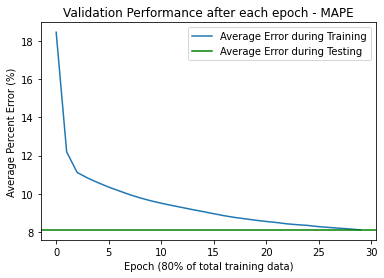

In [20]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.title("Validation Performance after each epoch - MAPE")
    plt.plot(history.history["mean_absolute_percentage_error"], label="Average Error during Training")
    plt.axhline(perf[1], color='g', label="Average Error during Testing")
    plt.xlabel("Epoch (80% of total training data)")
    plt.ylabel("Average Percent Error (%)")
    plt.legend()
    if save_figs:
        plt.savefig(f"plots/validation_performance_over_time_{parameter}.png", dpi=500)

In [21]:
if plot_figs and parameter == "fpe":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN after trainning to match NASA's NN June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Neural Network(estimated)",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network - MAPE",linewidth=2)
    ax0.set_title("Predicted vs Estimated Plasma Frequency")
    ax0.set_xlabel("parameterh Time (s)")
    ax0.set_ylabel("Plasma Frequency (kHz)")
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_NN")
    
    ax1.set_title("Difference between CNN and NN")
    ax1.set_xlabel("Epoch Time (s)")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig(f"plots/performance_on_test_dataset_fpe.png", dpi=500)

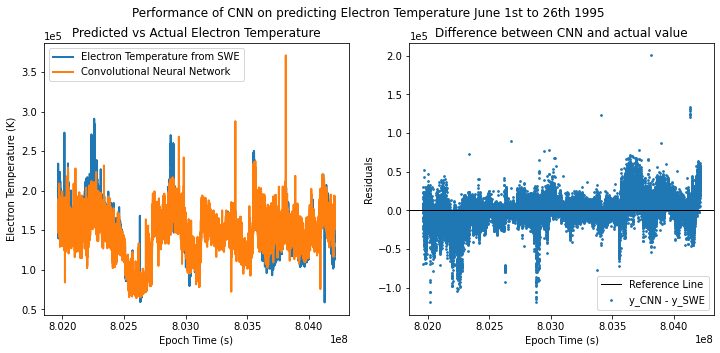

In [22]:
if plot_figs and parameter == "te":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN on predicting Electron Temperature June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Electron Temperature from SWE",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network",linewidth=2)
    ax0.set_title("Predicted vs Actual Electron Temperature")
    ax0.set_xlabel("Epoch Time (s)")
    ax0.set_ylabel("Electron Temperature (K)")
    ax0.ticklabel_format(axis='y', scilimits=[0,0])
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_SWE")
    
    ax1.set_title("Difference between CNN and actual value")
    ax1.set_xlabel("Epoch Time (s)")
    ax1.set_ylabel("Residuals")
    ax1.ticklabel_format(axis='y', scilimits=[0,0])
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig("plots/performance_on_test_dataset_te.png", dpi=500)

In [23]:
if plot_figs and parameter == "vsw":
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(6*2,5), facecolor='w')
    fig.suptitle("Performance of CNN on predicting Solar Wind Speed June 1st to 26th 1995")

    ax0.plot(test_time_sorted, denorm_test, label="Solar Wind Speed from SWE",linewidth=2)
    ax0.plot(test_time_sorted, denorm_pred, label="Convolutional Neural Network",linewidth=2)
    ax0.set_title("Predicted vs Actual Solar Wind Speed")
    ax0.set_xlabel("Epoch Time (s)")
    ax0.set_ylabel("Solar Wind Speed (km/s)")
    ax0.legend()

    res = np.subtract(denorm_pred,denorm_test)
    ax1.axhline(0, color='black', linewidth=1, label="Reference Line")
    ax1.scatter(test_time_sorted, res, s=3, label="y_CNN - y_SWE")
    
    ax1.set_title("Difference between CNN and actual value")
    ax1.set_xlabel("Epoch Time (s)")
    ax1.set_ylabel("Residuals")
    ax1.legend(loc='lower right')

    if save_figs:
        fig.savefig("plots/performance_on_test_dataset_vsw.png", dpi=500)

In [24]:
if plot_figs and False:
    # Not exactly sure of the purpose of this code
    def norm_dist(val, mean=np.mean(lst3), standard_dev=np.std(lst3)):
        factor = 1/np.sqrt(2*np.pi*(standard_dev**2))
        exp = np.exp(-(val - mean)**2/(2*(standard_dev**2)))
        return factor*exp

    x = [-2 + i*.1 for i in range(40)]
    y = [norm_dist(v)*3000 for v in x]

NameError: name 'x' is not defined

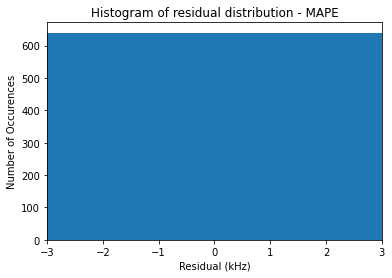

In [25]:
if plot_figs:
    fig, ax = plt.subplots(facecolor='w')
    ax.hist(lst3, 1000, histtype='bar')
    ax.set_xlim(-3,3)
    ax.set_title("Histogram of residual distribution - MAPE")
    ax.set_xlabel("Residual (kHz)")
    ax.set_ylabel("Number of Occurences")
    ax.plot(x,y)
    if save_figs:
        plt.savefig(f"plots/hist_error_{parameter}.png", dpi=500)

In [ ]:
assert False

In [ ]:
# Finding all outliers with a frequency error greater than 5
data_zip = list(filter(lambda x: abs(x[4])>10, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
test_time_sorted_outliers, test_x_sorted_outliers, test_y_sorted_outliers, pred_y_outliers, res_outliers = list(zip(*data_zip))

In [ ]:
# data_zip2 = list(filter(lambda x: abs(x[4])<.00003, zip(test_time_sorted, test_x_sorted, test_y_sorted, pred_y, res)))
# test_time_sorted_best, test_x_sorted_best, test_y_sorted_best, pred_y_best, res_best = list(zip(*data_zip2))

In [ ]:
if plot_figs:
    n = len(res_outliers)
    #plt.figure(figsize=(15, 4*n))
    fig, ax = plt.subplots(nrows=n, figsize=(9, 3*n), facecolor='w', dpi=200)

    for i in range(0, n):    
        ax[i].set_ylabel("V^2/Hz")
        ax[i].set_xlabel("Frequency (kHz)")
        ax[i].xaxis.set_label_coords(.5, -.04)
        ax[i].scatter(freq/1000, denorm(test_x_sorted_outliers[i], max_y), s=6,label='WIND data')
        ax[i].plot(freq/1000, denorm(test_x_sorted_outliers[i], max_y), markersize=1,label='WIND data')

        ax[i].axvline(x=denorm(pred_y_outliers, max_y)[i], color='r', label="CNN")
        ax[i].axvline(x=denorm(test_y_sorted_outliers, max_y)[i], color='g', label="NASA estimate")
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_ylim(1, 550)
        ax[i].set_xlim(3.5, 275)
        ax[i].set_aspect(.2)
        ax[i].text(4, 300, f"Plot #{i+1} - Residual: {np.round(res_outliers[i],2)}")
        ax[i].legend()

    fig.suptitle("The plot of the spectra with CNN and NASA estimate for plasma frequency", y=0.888)
    if save_figs:
        plt.savefig("plots/outliers.png", dpi=fig.dpi, bbox_inches='tight')


In [ ]:
if plot_figs:
    plt.figure(facecolor='w',figsize=(5,5))
    plt.scatter(denorm_pred, denorm_test, s=.1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Actual Value")
    if save_figs:
        plt.savefig("plots/plot_opposing_predictions.png")

In [ ]:
if plot_figs:
    plt.figure(figsize=(8,8), facecolor='w')
    plt.hist2d(denorm_pred, denorm_test, bins =[100, 100], density=True,cmap = plt.cm.Greys)
    plt.colorbar()
    if save_figs:
        plt.savefig("plots/2dhist3.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of NASA's NN Plasma Frequency Predictions")
    plt.hist(denorm_test, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    if save_figs:
        plt.savefig("plots/hist_nasa_nn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')

    plt.title("Histogram of CNN Plasma Frequency Predictions")
    plt.hist(denorm_pred, bins=80)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Number of occurences")
    if save_figs:
        plt.savefig("plots/hist_cnn_plasma_freq.png")

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.scatter(denorm_test, lst3, s=1)
    plt.axhline(0, color='r', linewidth=.5)
    plt.xlabel("NASA Predicted Plasma Frequency (kHz)")
    plt.ylabel("Residuals (kHz)")
    plt.title("Comparing change in residuals for each respective plasma frequency")
    if save_figs:
        plt.savefig("plots/residual_and_nasa_plasma_freq", dpi=500)
    plt.show()

In [ ]:
if plot_figs:
    plt.figure(facecolor='w')
    plt.hist2d(denorm_test, lst3, bins=[100,100])
    plt.xlabel("NASA's NN Plasma Frequency (kHz)")
    plt.ylabel("Residuals")
    plt.colorbar()
    if save_figs:
        plt.savefig("plots/resvsfp1.png")

## Conditional Probablity Distribution

In [ ]:
plotCPDfig = False

In [ ]:
if plotCPDfig:
    count = 0
    diff = 1.5
    int_denorm_test = np.array([int(f) for f in denorm_test])
        
    dist_error = np.array([[0,0] for _ in range(85)])

    for fpe in range(85):
        y_list = []
        
        for findex in np.where(int_denorm_test-fpe<.001)[0]:
            f = denorm_test[findex]
            indices = np.where(np.abs(denorm_pred-f)<diff)[0]
            y_list.extend(np.add(denorm_pred[indices],-f))
        
        if y_list:
            dist_error[fpe] = [np.mean(y_list), np.std(y_list)]

        if count%1==0:
            progress_bar(count/85)
        count += 1

In [ ]:
pd.DataFrame(int_denorm_test).describe()

In [ ]:
if plotCPDfig:
    with open("data/pickle/error_dist", 'rb') as file:
        data_dic = pickle.load(file=file)

    denorm_pred = np.array(data_dic["Pred_y"])
    denorm_test = np.array(data_dic["Act_y"])

    del(data_dic)
    gc.collect()

In [ ]:
if plotCPDfig:

    diff = 1.5
    count = 0

    hist2dlist = np.array([np.array([0 for _ in range(100)]) for _ in range(85)])

    print("Started")
    for f in denorm_test:
        indices = np.where(np.abs(denorm_pred-f)<diff)[0]
        
        x = int(f)
        y_list = np.multiply(np.add(denorm_pred[indices],1.5-f), 100/3)

        for y in y_list:
            # count up the x and y coords 
            hist2dlist[x, int(y)] += 1
            
        if count%5000==0:
            print(count)
        count += 1
    


In [ ]:
if plotCPDfig:

    cleanhist2dlist = hist2dlist[12:85]

    group = 3
    hist2dlist3 = []

    for i in range(len(cleanhist2dlist)//group):
        hist2dlist3.append(np.sum(cleanhist2dlist[group*i:group*i+group], axis=0))

    hist2dlist4 = np.array(hist2dlist3)

    # for i in range(int(len(hist2dlist4)/2),len(hist2dlist4),2):

    #     blur = 2

    #     if i+index>len(hist2dlist4):
    #         break
    #     sum_hist = hist2dlist4[i]
    #     for index in range(1,blur):
    #         sum_hist += hist2dlist4[i+index]
    #     for index in range(blur):
    #         hist2dlist3[i+index] = sum_hist
    

In [ ]:
if plotCPDfig:

    hist2dlist2 = [np.array(row[:]) for row in hist2dlist4]

    # for i in range(len(hist2dlist2)):
    #     if i>45 and False: # modify False/True if want to disable blur
    #         blur = 5#int(i/20+1)
    #         for j in range(len(hist2dlist2[i])):
    #             section = 5#j//blur 
    #             #sum_section = sum(hist2dlist[i,section*blur:section*blur+blur])
    #             try:
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,j:j+blur])
    #             except IndexError:
    #                 length = len(hist2dlist2[i])
    #                 hist2dlist2[i][j] = sum(hist2dlist[i,length-blur:length])

    for i in range(len(hist2dlist2)):
        min_val = min(hist2dlist2[i])
        range_val = max(*hist2dlist2[i], 1) - min(hist2dlist2[i])
        hist2dlist2[i] = np.divide(np.subtract(hist2dlist2[i], min_val), range_val)

In [ ]:
if plotCPDfig:

    fig, ax = plt.subplots(facecolor='w', figsize=(8,5))

    colors = ["#ffffff","#0000ff"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    psm = ax.pcolormesh(np.transpose(hist2dlist2),cmap = cmap1)#, norm=matplotlib.colors.LogNorm())
    #ax.set_xlim((12,85))

    tickmarks = [-1.5,-1,-.5,0,.5,1]
    ax.set_yticks(np.arange(0,100,100/len(tickmarks)))#[0,10,20,30,40,50,60,70,80,90])
    ax.set_yticklabels(tickmarks)

    tickmarks = np.round(np.array(list(range(1,24,5)))*3+12,1)
    ax.set_xticks(np.arange(1,len(hist2dlist2),len(hist2dlist2)/len(tickmarks)))
    ax.set_xticklabels(tickmarks)

    fig.colorbar(psm)

    ax.set_title("Conditional Probability Distribution for NASA's NN vs CNN Residuals")
    ax.set_xlabel("NASA's NN Plasma Frequency (kHz)")
    ax.set_ylabel("Residuals (kHz)")

    plt.savefig("plots/conditional_probability_distribution.png")
    plt.show()

## Pickle Stuff

In [ ]:
# with open("data/pickle/conditional_probx", 'rb') as file:
#     x = pickle.load(file=file)
    
# with open("data/pickle/conditional_proby", 'rb') as file:
#     y = pickle.load(file=file)

In [ ]:
# with open("data/pickle/conditional_probx", 'wb') as file:
#     pickle.dump(x, file=file)
# with open("data/pickle/conditional_proby", 'wb') as file:
#     pickle.dump(y, file=file)